In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]


In [217]:
import numpy as np
from scipy.special import kv, kvp, gamma



def gaussian_kernel(x, y, l=1.):
    return np.exp(-((x - y)**2).sum(-1) / l)


def make_kernels(X, Y, l=.1):

    n, dim = X.shape
    m = len(Y)



    kernel_func = gaussian_kernel


    K = kernel_func(X[:, None], Y, l)
    K += 1e-14 * np.eye(len(K)) # TODO: REVIEW. just to be sure with Cholesky
    Phi = np.linalg.cholesky(K).T

    return Phi, K



In [205]:
def predict(x, X, K, y):
    KxX = gaussian_kernel(x, X.reshape(-1, 1), l=.1)
    return KxX.T @ np.linalg.solve(K, y)

In [206]:
# logistic map

def logistic_map(r):
    def helper(x):
        return r * x * (1 - x)
    
    return helper

In [207]:
def gen_traj(r, x0, N):
    curr_map = logistic_map(r)

    x_curr = x0
    res = []
    for _ in range(N):
        res.append(x_curr)
        x_curr = curr_map(x_curr)

    res.append(x_curr)
    
    return res

def MMD_comp(k_func, X1, X2):
    res = 0
    m = len(X1)
    for i in range(m):
        for j in range(m):
            if i == j:
                continue
            res += k_func(X1[i], X1[j])
            res += k_func(X2[i], X2[j])
            res -= k_func(X1[i], X2[j])
            res -= k_func(X1[j], X2[i])
    return res / (m * (m - 1))
               
# learnable kernel 
def custom_kernel(theta):
    
    def kernel(x, y):
        c, d = theta
        return (x.T @ y + c)**d
    
    return kernel



In [134]:
def get_loss(X1, X2):
    
    def helper(theta):
        k_func = custom_kernel(theta)
        return MMD_comp(k_func, X1, X2)
        
    return helper

In [174]:
def get_Hgrad(alpha, fs, Phi, lmbda, eps):
    n = len(fs)
    grad = np.empty(n)
    pre_inv_term = Phi @ np.diag(alpha) @ Phi.T + lmbda * np.eye(n)
    for i in range(n):
        
        grad[i] = fs[i] - eps/n * Phi[:, i].T @ np.linalg.solve(pre_inv_term, Phi[:, i])
    return grad

def get_Hhess(alpha, fs, Phi, lmbda, eps):
    n = len(fs)
    hess = np.empty(shape=(n, n))
    pre_inv_term = Phi @ np.diag(alpha) @ Phi.T + lmbda * np.eye(n)
    for i in range(n):
        for j in range(n):
            hess[i, j] = eps/n * (Phi[:, i].T @ np.linalg.solve(pre_inv_term, Phi[:, j]))**2
    return hess

In [213]:
r = 1
x0 = 0.5
N = 100
traj = np.array(gen_traj(r, x0, N))
X = traj[:-1]
Y = traj[1:]

N_sub = 20
X1 = X[np.random.choice(len(X), N_sub)].reshape(-1, 1)
X2 = X[np.random.choice(len(X), N_sub)].reshape(-1, 1)


In [214]:
loss = get_loss(X1, X2)

In [215]:
cs = np.linspace(0, 2, 5)
ds = np.linspace(0.1, 2, 5)

XY = np.meshgrid(cs, ds)
thetas = np.vstack([xy.flatten() for xy in XY]).T
fs = [loss(t) for t in thetas]

In [218]:
Phi, K = make_kernels(thetas, thetas)

In [222]:
alpha = np.linspace(1, 10, len(fs))
alpha /= np.sum(alpha)
alpha

array([0.00727273, 0.01      , 0.01272727, 0.01545455, 0.01818182,
       0.02090909, 0.02363636, 0.02636364, 0.02909091, 0.03181818,
       0.03454545, 0.03727273, 0.04      , 0.04272727, 0.04545455,
       0.04818182, 0.05090909, 0.05363636, 0.05636364, 0.05909091,
       0.06181818, 0.06454545, 0.06727273, 0.07      , 0.07272727])

In [220]:
for _ in range(100):

    lmbda = 0.0001
    eps = 0.1
    n = len(alpha)

    hess = get_Hhess(alpha, fs, Phi, lmbda, eps)
    grad = get_Hgrad(alpha, fs, Phi, lmbda, eps)
    

    Hinv_grad = np.linalg.solve(hess, grad)
    Hinv_one = np.linalg.solve(hess, np.ones(n))
    delta = Hinv_grad - np.ones(n).T @ Hinv_grad / (np.ones(n).T @ Hinv_one) * Hinv_one
    newt_dec = delta.T @ hess @ delta
    print(newt_dec)
    alpha = alpha - 1/(1 + np.sqrt(n/ eps) * np.sqrt(newt_dec)) * delta

0.01936753969619073
0.013800426747998768
0.009229896314062938
0.005615708824114278
0.0029494327988612286
0.001215737193448927
0.0003261948211553231
3.8379868800149397e-05
8.315001340318994e-07
5.213148915664067e-10
2.331246896954897e-16
4.949849987696243e-29
5.6288521852048034e-33
9.340214973712721e-33
8.50509668823554e-33
1.4369378719857743e-33
3.712422380955683e-33
9.940608815909631e-33
2.8747468770552372e-33
8.022940197205058e-33
2.9944539618972178e-33
1.0777726188339643e-32
2.8747469108470816e-33
8.980410735966491e-33
2.9944539618972178e-33
1.0777726188339643e-32
2.8747469108470816e-33
8.980410735966491e-33
2.9944539618972178e-33
1.0777726188339643e-32
2.8747469108470816e-33
8.980410735966491e-33
2.9944539618972178e-33
1.0777726188339643e-32
2.8747469108470816e-33
8.980410735966491e-33
2.9944539618972178e-33
1.0777726188339643e-32
2.8747469108470816e-33
8.980410735966491e-33
2.9944539618972178e-33
1.0777726188339643e-32
2.8747469108470816e-33
8.980410735966491e-33
2.994453961897217

In [221]:
alpha

array([0.04005839, 0.0399754 , 0.03997355, 0.0399729 , 0.03997325,
       0.04008004, 0.03998687, 0.03998265, 0.0399807 , 0.0399802 ,
       0.03998838, 0.03999217, 0.03999293, 0.0399934 , 0.03999443,
       0.03997297, 0.03999326, 0.04000329, 0.0400111 , 0.04001845,
       0.0399723 , 0.03999321, 0.04001483, 0.04003648, 0.04005885])

In [8]:
# trajectories to dataset

tau = 1
X, y = [], []

for i in range(len(traj) - tau):
    X.append(traj[i:i+tau])
    y.append(traj[i+tau])

X, y = np.array(X), np.array(y)

In [9]:
# bifurcations
N_init = 20
N_rs = 100

init_conds = np.linspace(0, 1, N_init)

rs = np.linspace(0, 4, N_rs)
maps = [logistic_map(r) for r in rs]

N_iters = 100

res = np.empty((N_iters, N_init, N_rs))


for i in range(N_iters):
    for j in range(N_init):
        for k in range(N_rs):
            if i == 0:
                res[i, j, k] = init_conds[j]
            else:
                res[i, j, k] = maps[k](res[i - 1, j, k])
                

               
        
        


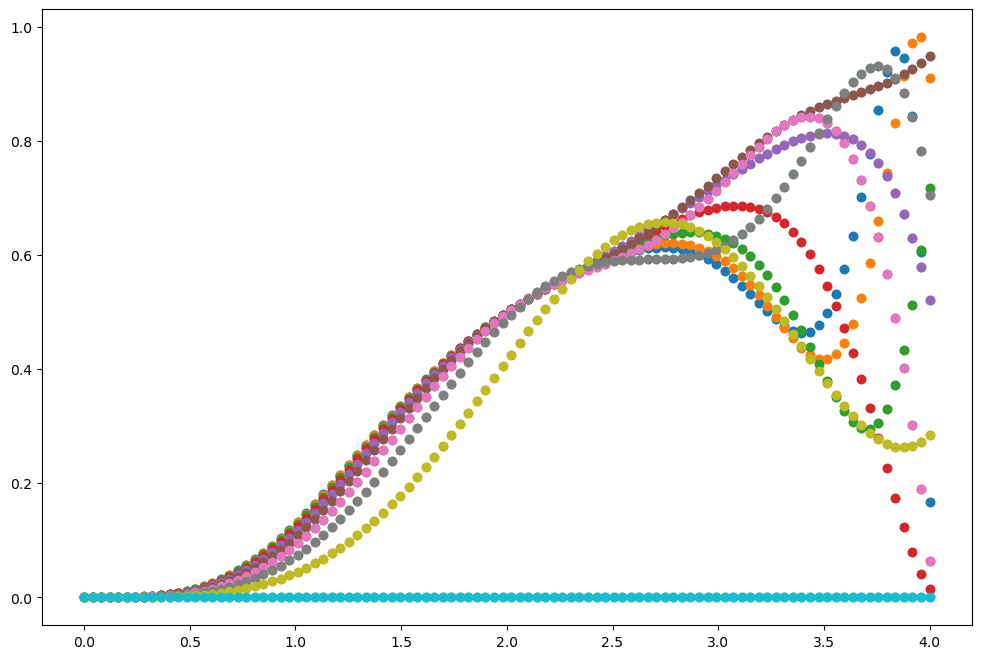

In [10]:
n_iter = 4

for j in range(N_init):
    plt.scatter(rs, res[n_iter, j, :])